In [191]:
import xarray as xr
import matplotlib.pyplot as plt
import xesmf as xe
import numpy as np
import copy
import glob

In [195]:

ds = xr.open_dataset('testData/gfs_2015_02_05_09.nc',decode_cf=False)

In [186]:

REGRIDDERS={}
def get_vars_contain_lon(ds):
    vars = []
    for var in ds.variables:
        if var in ds[var].coords: continue
        if 'lon' in ds[var].coords:
            vars.append(var)
    return vars

def get_vars_contain_lat(ds):
    vars = []
    for var in ds.variables:
        if var in ds[var].coords: continue
        if 'lat' in ds[var].coords:
            vars.append(var)
    return vars

def get_lonsperlat(ds):
    return ds['lon'].attrs['lonsperlat']

def get_decomp(ds):
    decomp = ds['lat'].attrs['decomp_gfs']
    return decomp

def get_globalNlat(ds):
    return ds['lat'].attrs['domain_decomposition'][1]

def set_regridders(ds, method='nearest_s2d'):
    global REGRIDDERS
    lon = ds['lon']
    maxlon = lon.shape[0]
    ds_out = xr.Dataset({ 
        "lat": (["lat"], [0.0]),
        "lon": (["lon"], lon.values),
        })
    lonsperlat = get_lonsperlat(ds)
    for nlon in lonsperlat:
        if nlon == maxlon: continue
        indx = (maxlon, nlon, method,)
        if indx in REGRIDDERS: continue 
        dlon = 360.0/nlon
        olon = [0.0,]
        for i in range(1,nlon):
            olon.append(olon[i-1]+dlon)
        ds_in = xr.Dataset({ 
            "lat": (["lat"], [0.0]),
            "lon": (["lon"], olon),
            })
        REGRIDDERS[indx] = xe.Regridder(
            ds_in=ds_in, 
            ds_out=ds_out, 
            method=method, 
            periodic=True, 
            )
    return maxlon, method

def regrid_red2reg(ds, method='nearest_s2d'):
    vars = get_vars_contain_lon(ds)
    lonsperlat = get_lonsperlat(ds)
    maxlon, _ = set_regridders(ds,method)
    for var in vars:
        if len(ds[var].shape) == 2:
            # lat, lon
            for lat in range(ds[var].shape[0]):
                nlon = lonsperlat[lat]
                if nlon==maxlon: continue
                #print(f'nlon={nlon}')
                regridder = REGRIDDERS[(maxlon, nlon, method,)]
                data_in = ds[var].values[lat:lat+1,0:nlon]
                ds[var].values[lat:lat+1,:] = regridder(data_in)
        elif len(ds[var].shape) == 3:
            # [time or lev], lat, lon
            for t in range(ds[var].shape[0]):
                for lat in range(ds[var].shape[1]):
                    nlon = lonsperlat[lat]
                    if nlon==maxlon: continue
                    #print(f'nlon={nlon}')
                    regridder = REGRIDDERS[(maxlon, nlon, method,)]
                    data_in = ds[var].values[t,lat:lat+1,0:nlon]
                    ds[var].values[t,lat:lat+1,:] = regridder(data_in)
        elif len(ds[var].shape) == 4:
            # time, lev, lat, lon
            for t in range(ds[var].shape[0]):
                for k in range(ds[var].shape[1]):
                    for lat in range(ds[var].shape[2]):
                        nlon = lonsperlat[lat]
                        if nlon==maxlon: continue
                        #print(f'nlon={nlon}')
                        regridder = REGRIDDERS[(maxlon, nlon, method,)]
                        data_in = ds[var].values[t,k,lat:lat+1,0:nlon]
                        ds[var].values[t,k,lat:lat+1,:] = regridder(data_in)
    ds['lon'].attrs.pop('lonsperlat')

def create_combine_ds(ds):
    ds_out = ds.drop_dims('lat')
    nlatGlobal = get_globalNlat(ds)
    lat_attrs = copy.deepcopy(ds['lat'].attrs)
    lat_attrs.pop('decomp_gfs')
    lat_data = np.array(range(nlatGlobal),dtype=ds['lat'].dtype)
    ds_out['lat'] = xr.DataArray(data=lat_data, dims=["lat"], attrs=lat_attrs)
    for var in get_vars_contain_lat(ds):
        shp = list(ds[var].shape)
        latDimIdx = len(shp) - 2
        shp[latDimIdx] = nlatGlobal
        ds_out[var] = xr.DataArray(
            data=np.zeros(shp,dtype=ds[var].dtype),
            dims=ds[var].dims,
            attrs=ds[var].attrs
        )
    return ds_out

def update_combine_ds(ds_out,ds):
    i = 0
    decomp=get_decomp(ds)
    for i in range(len(decomp)):
        j = decomp[i]
        ds_out['lat'].values[j] = ds['lat'].values[i]
        for var in get_vars_contain_lat(ds):
            if len(ds_out[var].shape) == 2:
                ds_out[var].values[j,:] = ds[var].values[i,:]
            elif len(ds_out[var].shape) == 3:
                ds_out[var].values[:,j,:] = ds[var].values[:,i,:]
            elif len(ds_out[var].shape) == 4:
                ds_out[var].values[:,:,j,:] = ds[var].values[:,:,i,:]
            else:
                raise Exception('Wrong variable dimension')

                    

                
    

In [192]:
input_files = glob.glob('testData/gfs_2015_02_05_09.nc.????')

In [194]:
ds_out = create_combine_ds(input_files[0])

AttributeError: 'str' object has no attribute 'drop_dims'

In [189]:
create_combine_ds(ds)

<xarray.Dataset>
Dimensions:     (lon: 384, time: 1, lat: 190, nv: 2)
Coordinates:
  * lon         (lon) float64 0.0 0.9375 1.875 2.812 ... 356.2 357.2 358.1 359.1
  * time        (time) float64 1.323e+05
  * lat         (lat) float64 0.0 1.0 2.0 3.0 4.0 ... 186.0 187.0 188.0 189.0
  * nv          (nv) float64 1.0 2.0
Data variables:
    average_T1  (time) float64 ...
    average_T2  (time) float64 ...
    average_DT  (time) float64 ...
    time_bnds   (time, nv) float64 ...
    tsea        (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    NumFilesInSet:  0
    title:          MOM4ICE
    grid_type:      regular
    grid_tile:      N/A

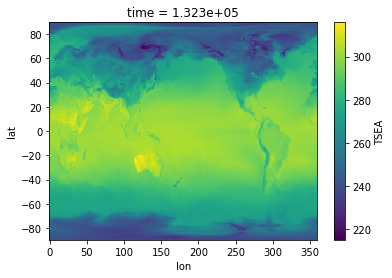

In [196]:
ds['tsea'].plot()